# A Good Modeling Example


As good as it gets&hellip;


## Contents

1. [Environment Initialisation](#Environment-Initialisation)
2. [Data Preparation](#Data-Preparation)
    1. [Synthetic Minority Oversampling Technique (SMOTE)](#Synthetic-Minority-Oversampling-Technique-%28SMOTE%29)
    2. [Correlation Reduction](#Correlation-Reduction)
3. [Model Construction](#Model-Construction)
    1. [Hyperparameter Optimisation](#Hyperparameter-Construction)
    2. [Final Model](#Final-Model)
    3. [Testing](#Testing)


## Environment Initialisation


In [1]:
%matplotlib inline


In [2]:
import copy
import math
import numbers
import os
import pickle
import sys


In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import scipy as sp
import scipy.optimize as opt
import scipy.special as spec
import scipy.stats as stats


In [4]:
import sklearn as skl
import sklearn.decomposition as skldec
import sklearn.linear_model as skllm
import sklearn.metrics as sklmet


In [5]:
import tensorflow as tf
import tensorflow_addons as tfa

import tensorflow.keras as keras
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as callbacks
import tensorflow.keras.layers as layers
import tensorflow.keras.losses as losses
import tensorflow.keras.metrics as metrics
import tensorflow.keras.models as models
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.utils as utils
import tensorflow_addons.losses as tfa_losses
import tensorflow_addons.metrics as tfa_metrics


2022-05-03 16:29:35.555905: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-03 16:29:35.556000: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [6]:
import hyperopt as hopt


In [7]:
import networkx as nx


In [8]:
import seaborn as sns


In [9]:
plt.style.use('seaborn')
sns.set_theme()


The following versions were used in the development of this *Jupyter Notebook*:


In [10]:
print(
    "Python version: " \
        f"{sys.version_info.major}." \
        f"{sys.version_info.minor}." \
        f"{sys.version_info.micro}"
)

print(f"Scipy version: {sp.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {mpl.__version__}")

print(f"scikit-learn version: {skl.__version__}")

print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

print(f"Hyperopt version: {hopt.__version__}")

print(f"NetworkX version: {nx.__version__}")

print(f"Seaborn version: {sns.__version__}")


Python version: 3.8.10
Scipy version: 1.7.1
NumPy version: 1.19.2
Pandas version: 1.3.1
Matplotlib version: 3.4.2
scikit-learn version: 0.24.2
Tensorflow version: 2.5.0
Keras version: 2.5.0
Hyperopt version: 0.2.5
NetworkX version: 2.6.2
Seaborn version: 0.11.1


In [11]:
import utils as myutils


## Data Preparation


In [12]:
data_root = 'data'
arrays_root = 'arrays'
models_root = 'models'


In [13]:
df = pd.read_csv(
    os.path.join(data_root, 'scores.csv'),
    sep = ';',
    header = 0,
    index_col = None,
    decimal = ','
)


In [14]:
labels = pd.read_csv(
    os.path.join(data_root, 'labels.csv'),
    sep = ';',
    header = 0,
    index_col = None,
    decimal = ','
)


In [15]:
df = df.merge(labels, how = 'left', on = 'country')


In [16]:
del labels


In [17]:
df = df.reindex(
    [
        'year',
        'country',
        'label',
        'score',
        'nscore',
        'rank'
    ],
    axis = 1
).reset_index(drop = True).copy(deep = True)


In [18]:
R = np.random.default_rng(2022)


In [19]:
year = 1990


In [20]:
X_train = list()
year_train = list()
time_train = list()
pos_train = list()
diverse_train = list()
y_train = list()

X_valid = list()
year_valid = list()
time_valid = list()
pos_valid = list()
diverse_valid = list()
y_valid = list()

for y in range(year - 10, year):
    trains = np.load(os.path.join(arrays_root, str(y), 'train.npy'))

    I = df.index[df.year == y]

    for i in I:
        c = str(np.asarray(df.loc[i, 'country']).item())
        a = np.asarray(df.loc[i, 'year']).item()
        s = np.asarray(df.loc[i, 'nscore']).item()

        x = np.load(os.path.join(arrays_root, str(y), c, 'taggram.npy'))
        t = np.load(os.path.join(arrays_root, str(y), c, 't.npy'))
        p = np.load(os.path.join(arrays_root, str(y), c, 'p.npy'))
        d = np.load(os.path.join(arrays_root, str(y), c, 'diverse.npy'))

        if np.asarray(df.loc[i, 'label']).item() in trains:
            X_train.append(x)
            year_train.append(np.full(x.shape[0], a, dtype = x.dtype))
            time_train.append(np.full(x.shape[0], t, dtype = x.dtype))
            pos_train.append(np.full(x.shape[0], p, dtype = x.dtype))
            diverse_train.append(np.full(x.shape[0], d, dtype = x.dtype))
            y_train.append(np.full(x.shape[0], s, dtype = x.dtype))
        else:
            X_valid.append(x)
            year_valid.append(np.full(x.shape[0], a, dtype = x.dtype))
            time_valid.append(np.full(x.shape[0], t, dtype = x.dtype))
            pos_valid.append(np.full(x.shape[0], p, dtype = x.dtype))
            diverse_valid.append(np.full(x.shape[0], d, dtype = x.dtype))
            y_valid.append(np.full(x.shape[0], s, dtype = x.dtype))

X_train = np.concatenate(X_train, axis = 0)
year_train = np.squeeze(np.concatenate(year_train, axis = 0))
time_train = np.squeeze(np.concatenate(time_train, axis = 0))
pos_train = np.squeeze(np.concatenate(pos_train, axis = 0))
diverse_train = np.squeeze(np.concatenate(diverse_train, axis = 0))
y_train = np.squeeze(np.concatenate(y_train, axis = 0))

X_valid = np.concatenate(X_valid, axis = 0)
year_valid = np.squeeze(np.concatenate(year_valid, axis = 0))
time_valid = np.squeeze(np.concatenate(time_valid, axis = 0))
pos_valid = np.squeeze(np.concatenate(pos_valid, axis = 0))
diverse_valid = np.squeeze(np.concatenate(diverse_valid, axis = 0))
y_valid = np.squeeze(np.concatenate(y_valid, axis = 0))


In [21]:
I = R.permutation(y_train.shape[0])

X_train = X_train[I].copy()
year_train = year_train[I].copy()
time_train = time_train[I].copy()
pos_train = pos_train[I].copy()
diverse_train = diverse_train[I].copy()
y_train = y_train[I].copy()

I = R.permutation(y_valid.shape[0])

X_valid = X_valid[I].copy()
year_valid = year_valid[I].copy()
time_valid = time_valid[I].copy()
pos_valid = pos_valid[I].copy()
diverse_valid = diverse_valid[I].copy()
y_valid = y_valid[I].copy()


In [22]:
feat_df_train = pd.DataFrame(
    np.concatenate(
        (
            X_train,
            np.expand_dims(year_train.astype(np.float32), axis = 1),
            np.expand_dims(time_train, axis = 1),
            np.expand_dims(pos_train, axis = 1),
            np.expand_dims(diverse_train, axis = 1),
            np.expand_dims(y_train, axis = 1)
        ),
        axis = 1
    ),
    columns = pd.Index(
        list(f"p_{i + 1:d}" for i in range(int(X_train.shape[1]))) +
            [ 'y', 't', 'p', 'd', 's' ],
        dtype = np.str_,
        name = 'feature'
    )
)

feat_df_valid = pd.DataFrame(
    np.concatenate(
        (
            X_valid,
            np.expand_dims(year_valid, axis = 1),
            np.expand_dims(time_valid, axis = 1),
            np.expand_dims(pos_valid, axis = 1),
            np.expand_dims(diverse_valid, axis = 1),
            np.expand_dims(y_valid, axis = 1)
        ),
        axis = 1
    ),
    columns = pd.Index(
        list(f"p_{i + 1:d}" for i in range(int(X_train.shape[1]))) +
            [ 'y', 't', 'p', 'd', 's' ],
        dtype = np.str_,
        name = 'feature'
    )
)

mcnnt_col = pd.Index(
    list(f"p_{i + 1:d}" for i in range(int(X_train.shape[1]))),
    dtype = np.str_,
    name = 'feature'
)
pos_col = 'p'
time_col = 't'
diverse_col = 'd'
year_col = 'y'
score_col = 's'

X_col = pd.Index(
    list(mcnnt_col) + [ 'p', 't', 'd', 'y' ],
    dtype = np.str_,
    name = 'feature'
)
X_scalar_col = pd.Index(
    [ 'p', 't', 'd', 'y' ],
    dtype = np.str_,
    name = 'feature'
)
y_col = score_col


### Synthetic Minority Oversampling Technique (SMOTE)


SMOTE is done by oversampling minority bins in histogram. Histogram is first done in $ 2 $ equally wide bins (halves), then $ 3 $ (thirds) and so on; in each iteration, all bins that have less than the maximal number of samples are oversampled using SMOTE. SMOTE skips sampling from a combination of samples $ x $ and $ y $ if their years are more than $ 2 $ apart.


In [23]:
def SMOTE (feat_df, low = 0, high = 5.5, max_bins = 12):
    for b in range(2, max_bins + 1):
        bin_edges = np.linspace(low, high, num = b + 1, dtype = np.float32)
        bin_edges[-1] += 1.0e-8

        hist, _ = np.histogram(
            feat_df['s'],
            bins = bin_edges,
            density = False
        )

        n_max = np.amax(hist)

        for k in range(b):
            if hist[k] < 2 or hist[k] == n_max:
                continue

            ind = feat_df.index[
                (feat_df['s'] >= bin_edges[k]) &
                (feat_df['s'] < bin_edges[k + 1])
            ]
            years = np.asarray(feat_df.loc[ind, 'y'].values)
            year_diffs = np.absolute(
                np.expand_dims(years, axis = 0) -
                    np.expand_dims(years, axis = 1)
            )
            year_diffs = (year_diffs > 2)

            n_diff = n_max - hist[k]

            I = np.zeros((n_diff, 2), dtype = np.int32)
            while True:
                J = ((I[:, 0] == I[:, 1]) | year_diffs[I[:, 0], I[:, 1]])
                n_g = np.sum(J)

                if not n_g:
                    break

                I[J] = R.choice(hist[k], size = (n_g, 2), replace = True)

            t = R.uniform(0, 1, size = (n_diff, 1))

            gen_df = \
                t * feat_df.loc[ind[I[:, 0]]].reset_index(drop = True) + \
                    (1 - t) * feat_df.loc[ind[I[:, 1]]].reset_index(drop = True)

            feat_df = pd.concat(
                (feat_df, gen_df),
                axis = 0,
                ignore_index = True
            )

    return feat_df


In [24]:
display(feat_df_train.shape)
display(feat_df_valid.shape)


(1776, 55)

(624, 55)

In [25]:
feat_df_train = SMOTE(feat_df_train, max_bins = 12)
feat_df_valid = SMOTE(feat_df_valid, max_bins = 12)


In [26]:
display(feat_df_train.shape)
display(feat_df_valid.shape)


(48482, 55)

(18858, 55)

In [27]:
feat_df_train['y'] = np.around(feat_df_train['y']).astype(np.int32)
feat_df_valid['y'] = np.around(feat_df_valid['y']).astype(np.int32)


### Correlation Reduction


In [28]:
def observe_correlations (X, **fig_kwargs):
    fig = plt.figure(**fig_kwargs)
    ax = fig.add_subplot(111)

    corr, corr_p = stats.spearmanr(X, axis = 0)
    corr[np.eye(corr.shape[0], dtype = np.bool_)] = 0

    corr_mask = np.triu(np.ones_like(corr, dtype = np.bool_))

    sns.heatmap(
        corr,
        mask = corr_mask,
        vmin = -1,
        vmax = 1,
        center = 0,
        square = True,
        linewidths = 0,
        cmap = 'coolwarm'
    )

    corr_aux = corr.copy(order = 'C')

    corr_aux[~corr_mask] = -np.inf
    i_max = np.unravel_index(np.argmax(corr_aux), shape = corr.shape, order = 'C')

    corr_aux[~corr_mask] = np.inf
    i_min = np.unravel_index(np.argmin(corr_aux), shape = corr.shape, order = 'C')

    print(f"{i_max[0]}, {i_max[1]}: {corr[i_max]:.2%}")
    print(f"{i_min[0]}, {i_min[1]}: {corr[i_min]:.2%}")

    return (corr, fig, ax)


5, 31: 99.16%
19, 20: -72.02%


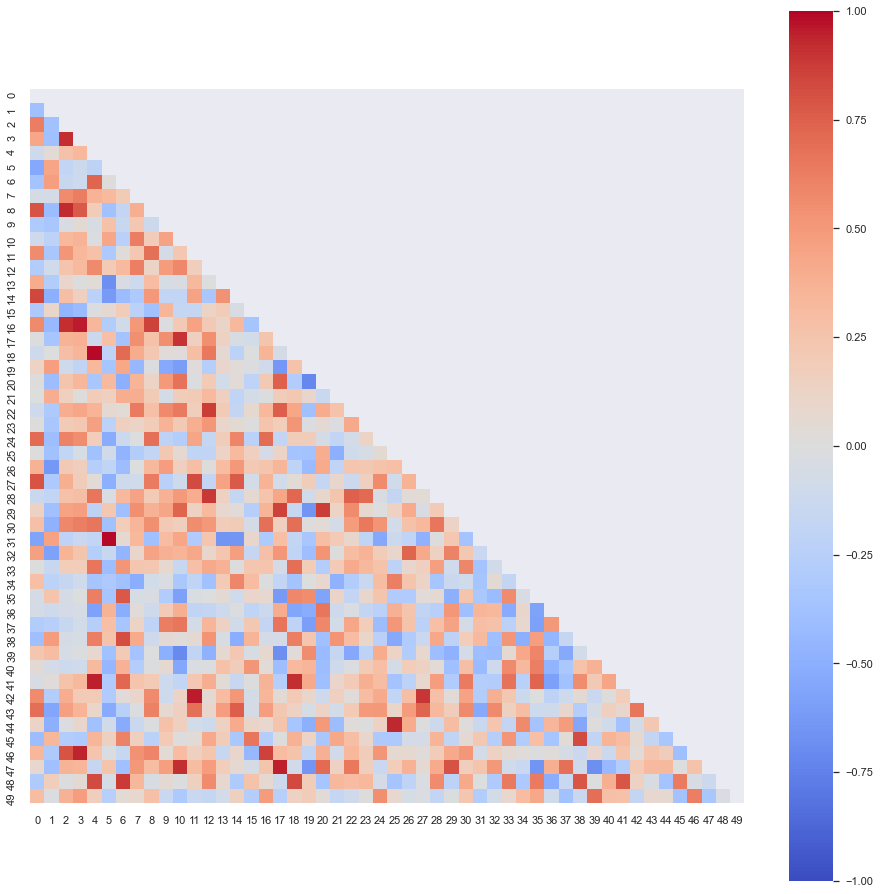

In [29]:
observe_correlations(
    feat_df_train.loc[:, mcnnt_col],
    figsize = (16, 16)
)

plt.show()


In [30]:
svd = skldec.TruncatedSVD(
    n_components = X_train.shape[1] - 1,
    random_state = R.integers(np.iinfo(np.int32).max)
)
svd.fit(feat_df_train.loc[:, mcnnt_col])

n = np.argmax(np.cumsum(svd.explained_variance_ratio_) >= 0.9)

M = svd.components_[:n].copy(order = 'C')


In [31]:
M.shape


(6, 50)

0, 1: 45.39%
0, 2: -67.52%


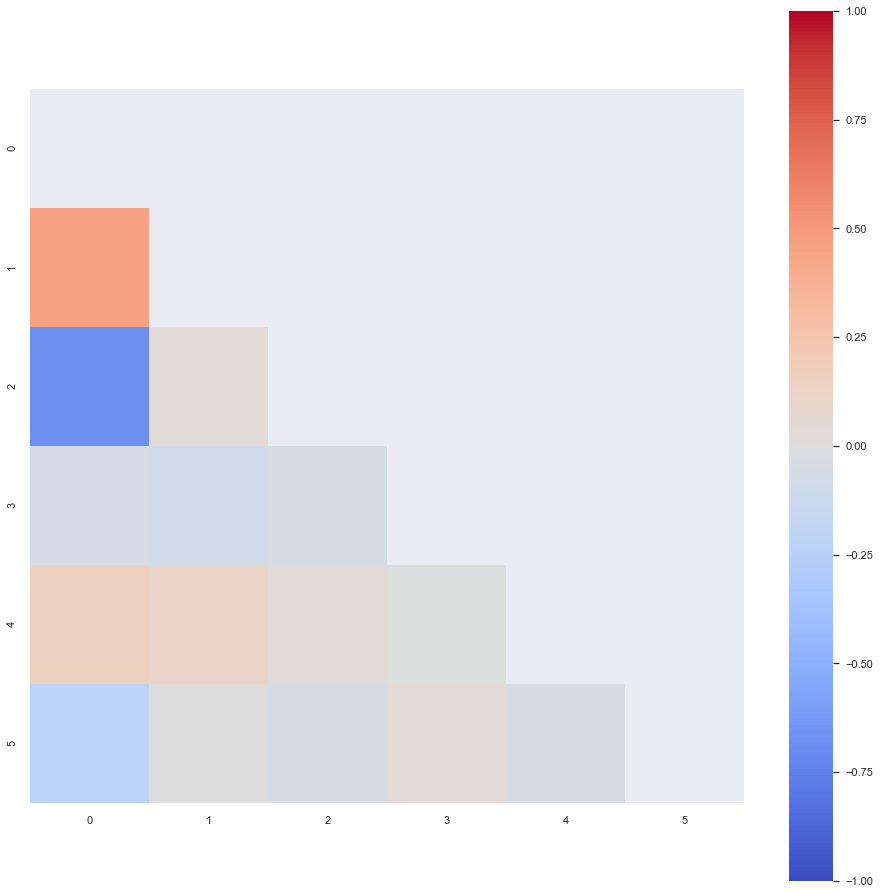

In [32]:
observe_correlations(
    np.matmul(feat_df_train.loc[:, mcnnt_col], M.T),
    figsize = (16, 16)
)

plt.show()


## Model Construction


In [33]:
def r2_score (y_true, y_pred, sample_weight = None):
    if sample_weight is None:
        sample_weight = K.ones_like(y_true, dtype = 'float32')

    sample_weight = sample_weight / K.sum(sample_weight)

    y_mean = K.sum(sample_weight * y_true)

    SS_res = K.sum(sample_weight * K.square(y_true - y_pred))
    SS_tot = K.maximum(
        K.sum(sample_weight * K.square(y_true - y_mean)),
        K.epsilon()
    )

    return 1 - SS_res / SS_tot

def neg_r2_score (y_true, y_pred, sample_weight = None):
    return -r2_score(y_true, y_pred, sample_weight)


### Hyperparameter Optimisation


In [34]:
def construct_model (args):
    """Returns inputs, outputs and number of parameters."""
    m_in = 0
    m_out = 0
    n = 0

    inputs = layers.Input(
        shape = M.shape[0] + X_scalar_col.size,
        name = 'input'
    )
    outputs = inputs

    m_in = M.shape[0] + X_scalar_col.size

    j = 1
    for i in range(6):
        m_out = int(round(args[f"hidden_{i + 1:d}"]))

        if m_out > 1:
            outputs = layers.Dense(
                units = m_out,
                activation = 'relu',
                name = f"hidden_{j}"
            )(outputs)

            n += m_out * (m_in + 1)

            m_in = m_out

            j += 1

    outputs = layers.Dense(
        units = 1,
        activation = 'linear',
        name = 'output'
    )(outputs)

    n += m_in + 1

    return (inputs, outputs, n)

def objective (args):
    inputs, outputs, n = construct_model(args)

    if n > 2000:
        return { 'status': hopt.STATUS_FAIL }

    model = models.Model(
        inputs = inputs,
        outputs = outputs,
        name = 'model'
    )

    model.compile(
        optimizer = optimizers.Adadelta(
            learning_rate = 1.0e-3,
            name = 'optimiser'
        ),
        loss = 'mean_squared_error',
        metrics = [ r2_score ]
    )

    history = model.fit(
        x = np.concatenate(
            (
                np.matmul(feat_df_train[mcnnt_col], M.T),
                feat_df_train[X_scalar_col]
            ),
            axis = 1
        ),
        y = feat_df_train[y_col],
        validation_data = (
            np.concatenate(
                (
                    np.matmul(feat_df_valid[mcnnt_col], M.T),
                    feat_df_valid[X_scalar_col]
                ),
                axis = 1
            ),
            feat_df_valid[y_col]
        ),
        shuffle = True,
        batch_size = 256,
        epochs = 100,
        verbose = 0,
        use_multiprocessing = False,
        callbacks = [
            callbacks.TerminateOnNaN(),
            callbacks.EarlyStopping(
                monitor = 'val_loss',
                patience = 4,
                mode = 'min',
                restore_best_weights = True
            ),
            callbacks.ReduceLROnPlateau(
                monitor = 'val_loss',
                patience = 2,
                mode = 'min',
                factor = 0.5
            )
        ]
    )

    loss = np.asanyarray(history.history['val_loss'])
    r2 = np.asanyarray(history.history['val_r2_score'])

    return {
        'status': hopt.STATUS_OK,
        'nparams': n,
        'loss': -math.log(n) * r2[np.argmin(loss)]
    }


In [35]:
# Setting the number of units to 1 will actually omit the hidden layer.
space = dict(
    (
        f"hidden_{i + 1:d}",
        hopt.hp.quniform(
            f"hidden_{i + 1:d}",
            1,
            int(round(math.ceil(20.0 / (i + 1)))),
            1
        )
    ) for i in range(6)
)


In [36]:
trials = hopt.Trials()
best = hopt.fmin(
    objective,
    space = space,
    algo = hopt.tpe.suggest,
    max_evals = 100,
    trials = trials
)
with open('hyperopt_trials.pkl', 'wb') as trials_output:
    pickle.dump(trials, trials_output, fix_imports = True)


  0%|                                   | 0/250 [00:00<?, ?trial/s, best loss=?]

2022-05-03 16:29:46.807964: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-03 16:29:47.225480: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-03 16:29:47.225505: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (erato): /proc/driver/nvidia/version does not exist
2022-05-03 16:29:47.225976: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-03 16:29:47.378031: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
202

100%|█████| 250/250 [1:16:38<00:00, 18.39s/trial, best loss: 256920.06638376293]


In [37]:
best


{'hidden_1': 13.0,
 'hidden_2': 8.0,
 'hidden_3': 1.0,
 'hidden_4': 3.0,
 'hidden_5': 4.0,
 'hidden_6': 4.0}

### Final Model


In [38]:
inputs, outputs, n = construct_model(best)

model = models.Model(
    inputs = inputs,
    outputs = outputs,
    name = 'model'
)

model.compile(
    optimizer = optimizers.Adadelta(
        learning_rate = 1.0e-3,
        name = 'optimiser'
    ),
    loss = 'mean_squared_error',
    metrics = [
        metrics.RootMeanSquaredError(),
        r2_score,
        metrics.LogCoshError(),
        metrics.CosineSimilarity()
    ]
)


In [39]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 10)]              0         
_________________________________________________________________
hidden_1 (Dense)             (None, 13)                143       
_________________________________________________________________
hidden_2 (Dense)             (None, 8)                 112       
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 264
Trainable params: 264
Non-trainable params: 0
_________________________________________________________________


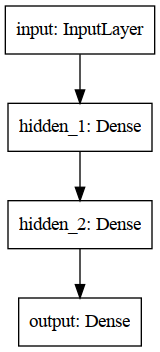

In [40]:
utils.plot_model(model)


In [41]:
history = model.fit(
    x = np.concatenate(
        (
            np.matmul(feat_df_train[mcnnt_col], M.T),
            feat_df_train[X_scalar_col]
        ),
        axis = 1
    ),
    y = feat_df_train[y_col],
    validation_data = (
        np.concatenate(
            (
                np.matmul(feat_df_valid[mcnnt_col], M.T),
                feat_df_valid[X_scalar_col]
            ),
            axis = 1
        ),
        feat_df_valid[y_col]
    ),
    shuffle = True,
    batch_size = 256,
    epochs = 2048,
    verbose = 0,
    use_multiprocessing = False,
    callbacks = [
        callbacks.TerminateOnNaN(),
        callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 64,
            mode = 'min',
            restore_best_weights = True
        ),
        callbacks.ReduceLROnPlateau(
            monitor = 'val_loss',
            patience = 2,
            mode = 'min',
            factor = 0.5
        )
    ]
)


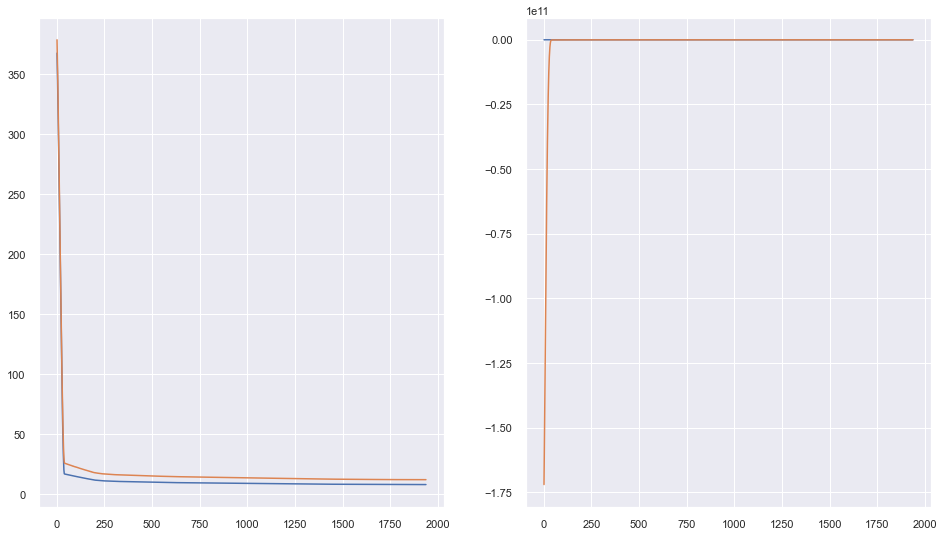

In [42]:
k = len(history.history['loss'])

fig, ax = plt.subplots(nrows = 1, ncols = 2, sharey = False, figsize = (16, 9))

ax[0].plot(
    list(range(1, k + 1)),
    history.history['root_mean_squared_error'][:k]
)
ax[0].plot(
    list(range(1, k + 1)),
    history.history['val_root_mean_squared_error'][:k]
)

ax[1].plot(
    list(range(1, k + 1)),
    history.history['r2_score'][:k]
)
ax[1].plot(
    list(range(1, k + 1)),
    history.history['val_r2_score'][:k]
)

plt.show()


### Testing


In [43]:
df_test = df.loc[df.year == year].copy(deep = True)
df_test['nscore_pred'] = np.zeros(df_test.shape[0])

pred_test = list()

for i in df.index[df.year == year]:
    X_test = list()
    year_test = list()
    time_test = list()
    pos_test = list()
    diverse_test = list()
    y_test = None

    c = str(np.asarray(df.loc[i, 'country']).item())
    a = np.asarray(df.loc[i, 'year']).item()
    s = np.asarray(df.loc[i, 'nscore']).item()

    x = np.load(os.path.join(arrays_root, str(year), c, 'taggram.npy'))
    t = np.load(os.path.join(arrays_root, str(year), c, 't.npy'))
    p = np.load(os.path.join(arrays_root, str(year), c, 'p.npy'))
    d = np.load(os.path.join(arrays_root, str(year), c, 'diverse.npy'))

    X_test = x
    year_test = np.full((x.shape[0], 1), a, dtype = x.dtype)
    time_test = np.full((x.shape[0], 1), t, dtype = x.dtype)
    pos_test = np.expand_dims(p, axis = 1)
    diverse_test = np.full((x.shape[0], 1), d, dtype = x.dtype)
    y_test = s

    y_test_pred = model.predict(
        np.concatenate(
            (
                np.matmul(X_test, M.T),
                pos_test - 0.5,
                time_test,
                diverse_test,
                year_test - (year - 5.5)
            ),
            axis = 1
        ),
        batch_size = 64
    ).ravel()

    df_test.loc[i, 'nscore_pred'] = np.quantile(y_test_pred, q = 0.25)

    pred_test.append((y_test, y_test_pred))

df_test.sort_values(
    by = [ 'score', 'country' ],
    ascending = [ False, True ],
    inplace = True
)
df_test.reset_index(drop = True, inplace = True)


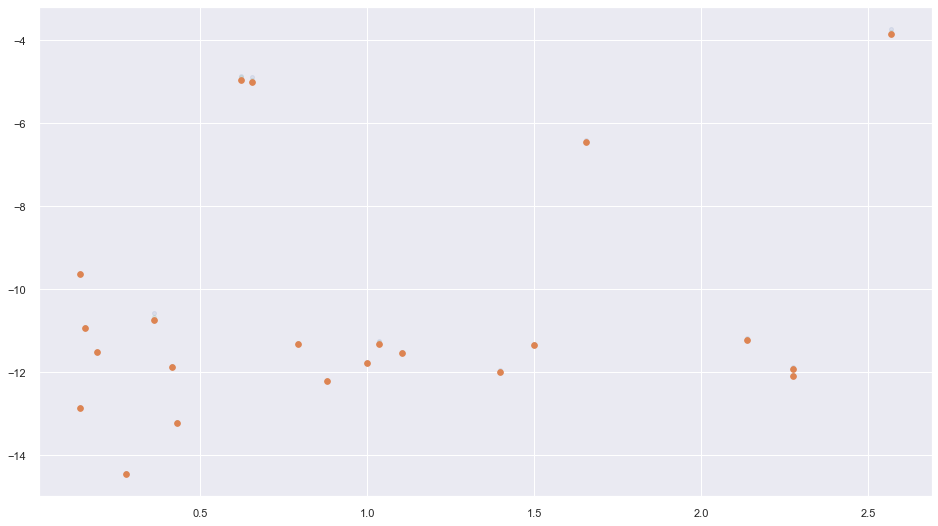

In [44]:
fig = plt.figure(figsize = (16, 9))

ax = fig.add_subplot(111)

ax.scatter(
    list(p[0] for p in pred_test),
    list(np.quantile(p[1], q = 0.75) for p in pred_test),
    color = 'C0',
    alpha = 0.1,
    s = 16
)
ax.scatter(
    list(p[0] for p in pred_test),
    list(np.quantile(p[1], q = 0.50) for p in pred_test),
    color = 'C2',
    alpha = 0.1,
    s = 16
)
ax.scatter(
    list(p[0] for p in pred_test),
    list(np.quantile(p[1], q = 0.25) for p in pred_test),
    color = 'C1',
    alpha = 1,
    s = 32
)

plt.show()


In [45]:
sklmet.r2_score(
    list(p[0] for p in pred_test),
    list(np.quantile(p[1], q = 0.75) for p in pred_test)
)


-242.09573637418862

In [46]:
df_test['rank_pred'] = myutils.rank_list(df_test['nscore_pred'], mode = 'center')


In [47]:
df_test


,year,country,label,score,nscore,rank,nscore_pred,rank_pred
0,1990,Italy,23,149,2.568966,0.0,-3.843122,0.0
1,1990,France,15,132,2.275862,1.5,-11.923203,15.0
2,1990,Ireland,21,132,2.275862,1.5,-12.077202,17.0
3,1990,Iceland,20,124,2.137931,3.0,-11.223209,7.0
4,1990,Spain,43,96,1.655172,4.0,-6.459607,3.0
5,1990,United Kingdom,48,87,1.500000,5.0,-11.335582,10.0
6,1990,Croatia,9,81,1.396552,6.0,-11.981139,16.0
7,1990,Denmark,12,64,1.103448,7.0,-11.530316,12.0
8,1990,Germany,17,60,1.034483,8.0,-11.322178,9.0
9,1990,Austria,3,58,1.000000,9.0,-11.773279,13.0
